# Assignment 1: Bandits and Exploration/Exploitation

Welcome to Assignment 1. This notebook will:
- Help you create your first bandit algorithm
- Help you understand the effect of epsilon on exploration and learn about the exploration/exploitation tradeoff
- Introduce you to some of the reinforcement learning software we are going to use for this specialization

This class uses RL-Glue to implement most of our experiments. It was originally designed by Adam White, Brian Tanner, and Rich Sutton. This library will give you a solid framework to understand how reinforcement learning experiments work and how to run your own. If it feels a little confusing at first, don't worry - we are going to walk you through it slowly and introduce you to more and more parts as you progress through the specialization.

We are assuming that you have used a Jupyter notebook before. But if not, it is quite simple. Simply press the run button, or shift+enter to run each of the cells. The places in the code that you need to fill in will be clearly marked for you.

## Section 0: Preliminaries

In [1]:
# Import necessary libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from rl_glue import RLGlue
import main_agent
import ten_arm_env
import test_env
from tqdm import tqdm
import time

In the above cell, we import the libraries we need for this assignment. We use numpy throughout the course and occasionally provide hints for which methods to use in numpy. Other than that we mostly use vanilla python and the occasional other library, such as matplotlib for making plots.

You might have noticed that we import ten_arm_env. This is the __10-armed Testbed__ introduced in [section 2.3](http://www.incompleteideas.net/book/RLbook2018.pdf) of the textbook. We use this throughout this notebook to test our bandit agents. It has 10 arms, which are the actions the agent can take. Pulling an arm generates a stochastic reward from a Gaussian distribution with unit-variance. For each action, the expected value of that action is randomly sampled from a normal distribution, at the start of each run. If you are unfamiliar with the 10-armed Testbed please review it in the textbook before continuing.

DO NOT IMPORT OTHER LIBRARIES as this will break the autograder.

## Section 1: Greedy Agent

We want to create an agent that will find the action with the highest expected reward. One way an agent could operate is to always choose the action with  the highest value based on the agent’s current estimates. This is called a greedy agent as it greedily chooses the action that it thinks has the highest value. Let's look at what happens in this case.

First we are going to implement the argmax function, which takes in a list of action values and returns an action with the highest value. Why are we implementing our own instead of using the argmax function that numpy uses? Numpy's argmax function returns the first instance of the highest value. We do not want that to happen as it biases the agent to choose a specific action in the case of ties. Instead we want to break ties between the highest values randomly. So we are going to implement our own argmax function. You may want to look at [np.random.choice](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html) to randomly select from a list of values.

In [2]:
# [Graded]
def argmax(q_values):
    """
    Takes in a list of q_values and returns the index
    of the item with the highest value. Breaks ties randomly.
    returns: int - the index of the highest value in q_values
    """
    top = float("-inf")
    ties = []
    
    for i in range(len(q_values)):
        # if a value in q_values is greater than the highest value, then update top and reset ties to zero
        # if a value is equal to top value, then add the index to ties (hint: do this no matter what)
        # return a random selection from ties. (hint: look at np.random.choice)
        ### START CODE HERE ###
        if q_values[i] > top:
            top = q_values[i]
            ties = [i]
        if q_values[i] == top:
            ties.append(i)
        
        ### END CODE HERE ###
    return np.random.choice(ties, 1)[0]

In [3]:
# Test argmax implentation
test_array = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
assert argmax(test_array) == 8, "Check your argmax implementation returns the index of the largest value"

test_array = [1, 0, 0, 1]
total = 0
for i in range(100):
    total += argmax(test_array)

assert total > 0, "Make sure your argmax implementation randomly choooses among the largest values."
assert total != 300, "Make sure your argmax implementation randomly choooses among the largest values."

In [4]:
# Do not modify this cell
# Test for Argmax Function
def test_argmax(): 
    test_array = [1, 0, 0, 1]
    total = 0
    for i in range(100):
        total += argmax(test_array)
    np.save("argmax_test", total)
    return total
test_argmax()

114

Now we introduce the first part of an RL-Glue agent that you will implement. Here we are going to create a GreedyAgent and implement the agent_step method. This method gets called each time the agent takes a step. The method has to return the action selected by the agent. This method also ensures the agent’s estimates are updated based on the signals it gets from the environment.

Fill in the code below to implement a greedy agent.

In [5]:
# Greedy agent here [Graded]
class GreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation):
        """
        Takes one step for the agent. It takes in a reward and observation and 
        returns the action the agent chooses at that time step.
        
        Arguments:
        reward -- float, the reward the agent received from the environment after taking the last action.
        observation -- float, the observed state the agent is in. Do not worry about this for this assignment 
        as you will not use it until future lessons.
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        ### Useful Class Variables ###
        # self.q_values : An array with the agent’s value estimates for each action.
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        # self.last_action : The action that the agent took on the previous time step.
        #######################
        
        # current action = ? # Use the argmax function you created above
        # (~2 lines)
        ### START CODE HERE ###
        current_action = argmax(self.q_values)
        ### END CODE HERE ###
        
        # Update action values. Hint: Look at the algorithm in section 2.4 of the textbook.
        # Increment the counter in self.arm_count for the action from the previous time step
        # Update the step size using self.arm_count
        # Update self.q_values for the action from the previous time step
        # (~3-5 lines)
        ### START CODE HERE ###
        self.arm_count[self.last_action] = self.arm_count[self.last_action] + 1
        self.q_values[self.last_action]  = self.q_values[self.last_action]  + 1/self.arm_count[self.last_action]*(reward - self.q_values[self.last_action])
        ### END CODE HERE ###
    
        self.last_action = current_action
        
        return current_action
        

In [6]:
# Do not modify this cell
# Test for Greedy Agent Code
greedy_agent = GreedyAgent()
greedy_agent.q_values = [0, 0, 1.0, 0, 0]
greedy_agent.arm_count = [0, 1, 0, 0, 0]
greedy_agent.last_action = 1
action = greedy_agent.agent_step(1, 0)
np.save("greedy_test", greedy_agent.q_values)
print("Output:")
print(greedy_agent.q_values)
print("Expected Output:")
print([0, 0.5, 1.0, 0, 0])

assert action == 2, "Check that you are using argmax to choose the action with the highest value."
assert greedy_agent.q_values == [0, 0.5, 1.0, 0, 0], "Check that you are updating q_values correctly."

Output:
[0, 0.5, 1.0, 0, 0]
Expected Output:
[0, 0.5, 1.0, 0, 0]


Let's visualize the result. Here we run an experiment using RL-Glue to test our agent. For now, we will set up the experiment code; in future lessons, we will walk you through running experiments so that you can create your own.

100%|██████████| 200/200 [00:04<00:00, 42.29it/s]


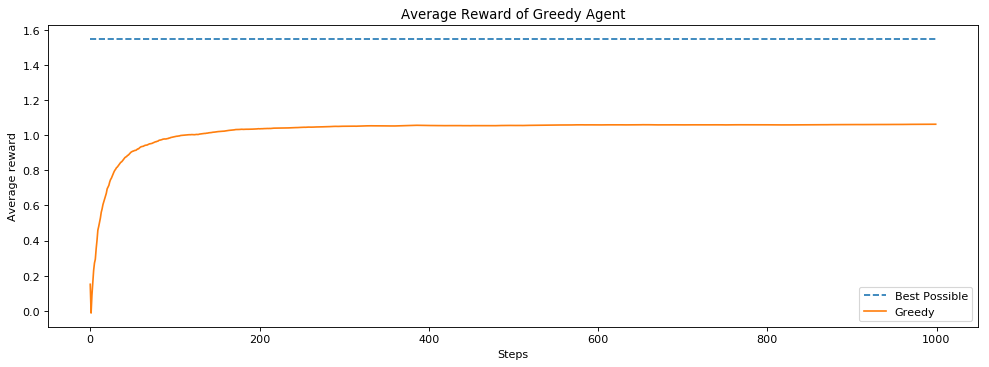

In [7]:
# Plot Greedy Result
num_runs = 200                    # The number of times we run the experiment
num_steps = 1000                  # The number of steps each experiment is run for
env = ten_arm_env.Environment     # We the environment to use
agent = GreedyAgent               # We choose what agent we want to use
agent_info = {"num_actions": 10}  # Pass the agent the information it needs; 
                                  # here it just needs the number of actions (number of arms).
env_info = {}                     # Pass the environment the information it needs; in this case, it is nothing.

all_averages = []

for i in tqdm(range(num_runs)):           # tqdm is what creates the progress bar below once the code is run
    rl_glue = RLGlue(env, agent)          # Creates a new RLGlue experiment with the env and agent we chose above
    rl_glue.rl_init(agent_info, env_info) # Pass RLGlue what it needs to initialize the agent and environment
    rl_glue.rl_start()                    # Start the experiment

    scores = [0]
    averages = []
    
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # The environment and agent take a step and return
                                                 # the reward, and action taken.
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    all_averages.append(averages)

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Best Possible", "Greedy"])
plt.title("Average Reward of Greedy Agent")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()
greedy_scores = np.mean(all_averages, axis=0)
np.save("greedy_scores", greedy_scores)

How did our agent do? Is it possible for it to do better?

## Section 2: Epsilon-Greedy Agent

We learned about [another way for an agent to operate](https://www.coursera.org/learn/fundamentals-of-reinforcement-learning/lecture/tHDck/what-is-the-trade-off), where it does not always take the greedy action. Instead, sometimes it takes an exploratory action. It does this so that it can find out what the best action really is. If we always choose what we think is the current best action is, we may miss out on taking the true best action, because we haven't explored enough times to find that best action.

Implement an epsilon-greedy agent below. Hint: we are implementing the algorithm from [section 2.4](http://www.incompleteideas.net/book/RLbook2018.pdf#page=52) of the textbook. You may want to use your greedy code from above and look at [np.random.random](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.random.html), as well as [np.random.randint](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html), to help you select random actions. 

In [8]:
# Epsilon Greedy Agent here [Graded]
class EpsilonGreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation):
        """
        Takes one step for the agent. It takes in a reward and observation and 
        returns the action the agent chooses at that time step.
        
        Arguments:
        reward -- float, the reward the agent received from the environment after taking the last action.
        observation -- float, the observed state the agent is in. Do not worry about this for this assignment 
        as you will not use it until future lessons.
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        
        ### Useful Class Variables ###
        # self.q_values : An array with the agent’s value estimates for each action.
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        # self.last_action : The action that the agent took on the previous time step.
        # self.epsilon : The probability an epsilon greedy agent will explore (ranges between 0 and 1)
        #######################
        
        # Choose action using epsilon greedy
        # Randomly choose a number between 0 and 1 and see if it is less than self.epsilon
        # (Hint: look at np.random.random()). If it is, set current_action to a random action.
        # Otherwise choose current_action greedily as you did above.
        # (~4 lines)
        ### START CODE HERE ###
        rnum = np.random.random()
        if rnum < self.epsilon: 
            current_action = np.random.choice(range(0, len(self.q_values)), 1)[0]
        else: 
            current_action = argmax(self.q_values)
            
        ### END CODE HERE ###
        
        # Update action-values - this should be the same update as your greedy agent above
        # (~3-5 lines)
        ### START CODE HERE ###
        self.arm_count[self.last_action] = self.arm_count[self.last_action] + 1
        self.q_values[self.last_action]  = self.q_values[self.last_action]  + 1/self.arm_count[self.last_action]*(reward - self.q_values[self.last_action])
        ### END CODE HERE ###
        
        self.last_action = current_action
        
        return current_action

In [ ]:
# Do not modify this cell
# Test Code for Epsilon Greedy Agent
e_greedy_agent = EpsilonGreedyAgent()
e_greedy_agent.q_values = [0, 0, 1.0, 0, 0]
e_greedy_agent.arm_count = [0, 1, 0, 0, 0]
e_greedy_agent.num_actions = 5
e_greedy_agent.last_action = 1
e_greedy_agent.epsilon = 0.5
action = e_greedy_agent.agent_step(1, 0)
print("Output:")
print(e_greedy_agent.q_values)
print("Expected Output:")
print([0, 0.5, 1.0, 0, 0])

# assert action == 2, "Check that you are using argmax to choose the action with the highest value."
assert e_greedy_agent.q_values == [0, 0.5, 1.0, 0, 0], "Check that you are updating q_values correctly."

Output:
[0, 0.5, 1.0, 0, 0]
Expected Output:
[0, 0.5, 1.0, 0, 0]


Now that we have our epsilon greedy agent created. Let's compare it against the greedy agent with epsilon of 0.1.

100%|██████████| 200/200 [00:04<00:00, 41.88it/s]


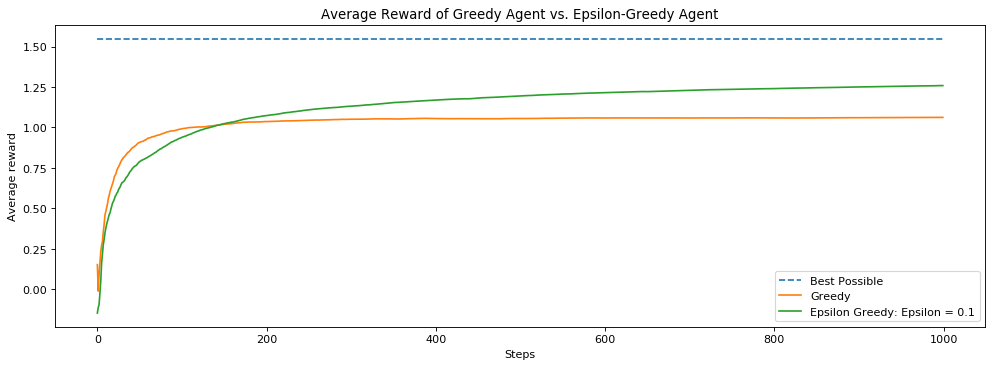

In [ ]:
# Plot Epsilon greedy results and greedy results
num_runs = 200
num_steps = 1000
epsilon = 0.1
agent = EpsilonGreedyAgent
env = ten_arm_env.Environment
agent_info = {"num_actions": 10, "epsilon": epsilon}
env_info = {}
all_averages = []

for i in tqdm(range(num_runs)):
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    scores = [0]
    averages = []
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # The environment and agent take a step and return
                                                 # the reward, and action taken.
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    all_averages.append(averages)

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")
plt.plot(greedy_scores)
plt.title("Average Reward of Greedy Agent vs. Epsilon-Greedy Agent")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(("Best Possible", "Greedy", "Epsilon Greedy: Epsilon = 0.1"))
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()
np.save("e-greedy", all_averages)

Notice how much better the epsilon-greedy agent did. Because we occasionally choose a random action we were able to find a better long term policy. By acting greedily before our value estimates are accurate, we risk settling on a suboptimal action.

## 1.2 Averaging Multiple Runs

Did you notice that we averaged over 2000 runs? Why did we do that?

To get some insight, let's look at the results of two individual runs by the same agent.

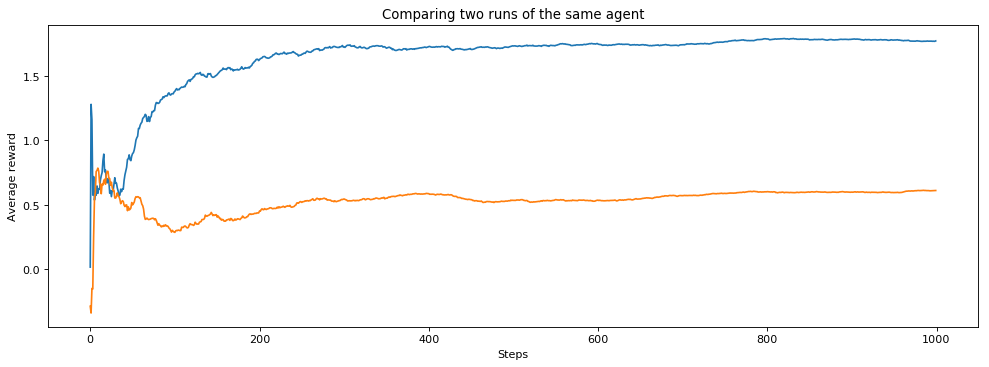

In [ ]:
# Plot runs of e-greedy agent
agent = EpsilonGreedyAgent
agent_info = {"num_actions": 10, "epsilon": 0.1}
env_info = {}
all_averages = []
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
num_steps = 1000

for run in (0, 1):
    np.random.seed(run) # Here we set the seed so that we can compare two different runs
    averages = []
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    scores = [0]
    for i in range(num_steps):
        reward, state, action, is_terminal = rl_glue.rl_step()
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
#     all_averages.append(averages)
    plt.plot(averages)

# plt.plot(greedy_scores)
plt.title("Comparing two runs of the same agent")
plt.xlabel("Steps")
plt.ylabel("Average reward")
# plt.plot(np.mean(all_averages, axis=0))
# plt.legend(("Greedy", "Epsilon: 0.1"))
plt.show()

Notice how the two runs were different? But, if this is the exact same algorithm, why does it behave differently in these two runs?

The answer is that it is due to randomness in the environment and in the agent. Depending on what action the agent randomly starts with, or when it randomly chooses to explore, it can change the results of the runs. And even if the agent chooses the same action, the reward from the environment is randomly sampled from a Gaussian. The agent could get lucky, and see larger rewards for the best action early on and so settle on the best action faster. Or, it could get unlucky and see smaller rewards for best action early on and so take longer to recognize that it is in fact the best action.

To be more concrete, let’s look at how many times an exploratory action is taken, for different seeds. 

In [ ]:
print("Random Seed 1")
np.random.seed(1)
for _ in range(15):
    if np.random.random() < 0.1:
        print("Exploratory Action")
    

print()
print()

print("Random Seed 2")
np.random.seed(2)
for _ in range(15):
    if np.random.random() < 0.1:
        print("Exploratory Action")

Random Seed 1
Exploratory Action
Exploratory Action
Exploratory Action


Random Seed 2
Exploratory Action


With the first seed, we take an exploratory action three times out of 15, but with the second, we only take an exploratory action once. This can significantly affect the performance of our agent because the amount of exploration has changed significantly.

To compare algorithms, we therefore report performance averaged across many runs. We do this to ensure that we are not simply reporting a result that is due to stochasticity, as explained [in the lectures](https://www.coursera.org/learn/fundamentals-of-reinforcement-learning/lecture/PtVBs/sequential-decision-making-with-evaluative-feedback). Rather, we want statistically significant outcomes. We will not use statistical significance tests in this course. Instead, because we have access to simulators for our experiments, we use the simpler strategy of running for a large number of runs and ensuring that the confidence intervals do not overlap. 

## Section 3: Comparing values of epsilon

Can we do better than an epsilon of 0.1? Let's try several different values for epsilon and see how they perform. We try different settings of key performance parameters to understand how the agent might perform under different conditions.

Below we run an experiment where we sweep over different values for epsilon:

100%|██████████| 200/200 [00:04<00:00, 40.53it/s]


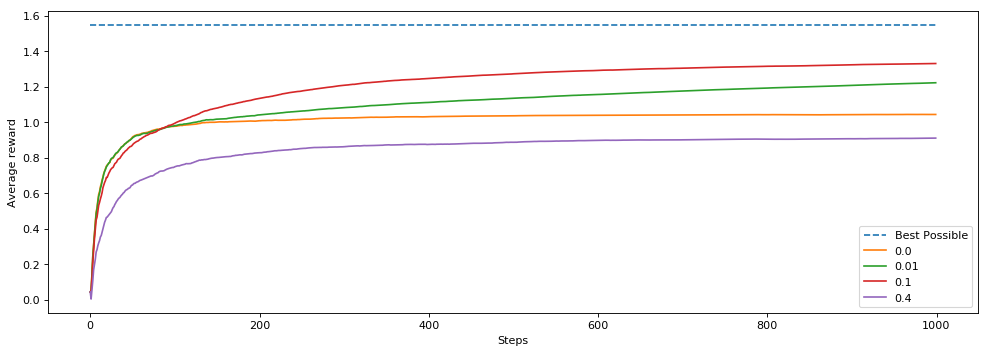

In [ ]:
# Experiment code for epsilon-greedy with different values of epsilon
epsilons = [0.0, 0.01, 0.1, 0.4]

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

n_q_values = []
n_averages = []
n_best_actions = []

num_runs = 200

for epsilon in epsilons:
    all_averages = []
    for run in tqdm(range(num_runs)):
        agent = EpsilonGreedyAgent
        agent_info = {"num_actions": 10, "epsilon": epsilon}
        env_info = {"random_seed": run}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()
        
        best_arm = np.argmax(rl_glue.environment.arms)

        scores = [0]
        averages = []
        best_action_chosen = []
        
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if epsilon == 0.1 and run == 0:
                n_q_values.append(np.copy(rl_glue.agent.q_values))
        if epsilon == 0.1:
            n_averages.append(averages)
            n_best_actions.append(best_action_chosen)
        all_averages.append(averages)
        
    plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Best Possible"] + epsilons)
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

Why did 0.1 perform better than 0.01?

If exploration helps why did 0.4 perform worse that 0.0 (the greedy agent)?

Think about these and how you would answer these questions. They are questions in the practice quiz. If you still have questions about it, retake the practice quiz.

## Section 4: The Effect of Step Size

In Section 1 of this assignment, we decayed the step size over time based on action-selection counts. The step-size was 1/N(A), where N(A) is the number of times action A was selected. This is the same as computing a sample average. We could also set the step size to be a constant value, such as 0.1. What would be the effect of doing that? And is it better to use a constant or the sample average method? 

To investigate this question, let’s start by creating a new agent that has a constant step size. This will be nearly identical to the agent created above. You will use the same code to select the epsilon-greedy action. You will change the update to have a constant step size instead of using the 1/N(A) update.

In [ ]:
# Constant Step Size Agent Here [Graded]
# Greedy agent here
class EpsilonGreedyAgentConstantStepsize(main_agent.Agent):
    def agent_step(self, reward, observation):
        """
        Takes one step for the agent. It takes in a reward and observation and 
        returns the action the agent chooses at that time step.
        
        Arguments:
        reward -- float, the reward the agent received from the environment after taking the last action.
        observation -- float, the observed state the agent is in. Do not worry about this for this assignment 
        as you will not use it until future lessons.
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        
        ### Useful Class Variables ###
        # self.q_values : An array with the agent’s value estimates for each action.
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        # self.last_action : The action that the agent took on the previous time step.
        # self.step_size : A float which is the current step size for the agent.
        # self.epsilon : The probability an epsilon greedy agent will explore (ranges between 0 and 1)
        #######################
        
        # Choose action using epsilon greedy. This is the same as you implemented above.
        # (~4 lines)
        ### START CODE HERE ###
        rnum = np.random.random()
        if rnum < self.epsilon: 
            current_action = np.random.choice(range(0, len(self.q_values)), 1)[0]
        else: 
            current_action = argmax(self.q_values)
        ### END CODE HERE ###
        
        # Update q_values for action taken at previous time step 
        # using self.step_size intead of using self.arm_count
        # (~1-2 lines)
        ### START CODE HERE ###
        self.arm_count[self.last_action] = self.arm_count[self.last_action] + 1
        self.q_values[self.last_action]  = self.q_values[self.last_action]  + self.step_size*(reward - self.q_values[self.last_action])

        ### END CODE HERE ###
        
        self.last_action = current_action
        
        return current_action

In [ ]:
# Do not modify this cell
# Test Code for Epsilon Greedy with Different Constant Stepsizes
for step_size in [0.01, 0.1, 0.5, 1.0]:
    e_greedy_agent = EpsilonGreedyAgentConstantStepsize()
    e_greedy_agent.q_values = [0, 0, 1.0, 0, 0]
    # e_greedy_agent.arm_count = [0, 1, 0, 0, 0]
    e_greedy_agent.num_actions = 5
    e_greedy_agent.last_action = 1
    e_greedy_agent.epsilon = 0.0
    e_greedy_agent.step_size = step_size
    action = e_greedy_agent.agent_step(1, 0)
    print("Output for step size: {}".format(step_size))
    print(e_greedy_agent.q_values)
    print("Expected Output:")
    print([0, step_size, 1.0, 0, 0])
    assert e_greedy_agent.q_values == [0, step_size, 1.0, 0, 0], "Check that you are updating q_values correctly using the stepsize."

Output for step size: 0.01
[0, 0.01, 1.0, 0, 0]
Expected Output:
[0, 0.01, 1.0, 0, 0]
Output for step size: 0.1
[0, 0.1, 1.0, 0, 0]
Expected Output:
[0, 0.1, 1.0, 0, 0]
Output for step size: 0.5
[0, 0.5, 1.0, 0, 0]
Expected Output:
[0, 0.5, 1.0, 0, 0]
Output for step size: 1.0
[0, 1.0, 1.0, 0, 0]
Expected Output:
[0, 1.0, 1.0, 0, 0]


100%|██████████| 200/200 [00:04<00:00, 42.44it/s]


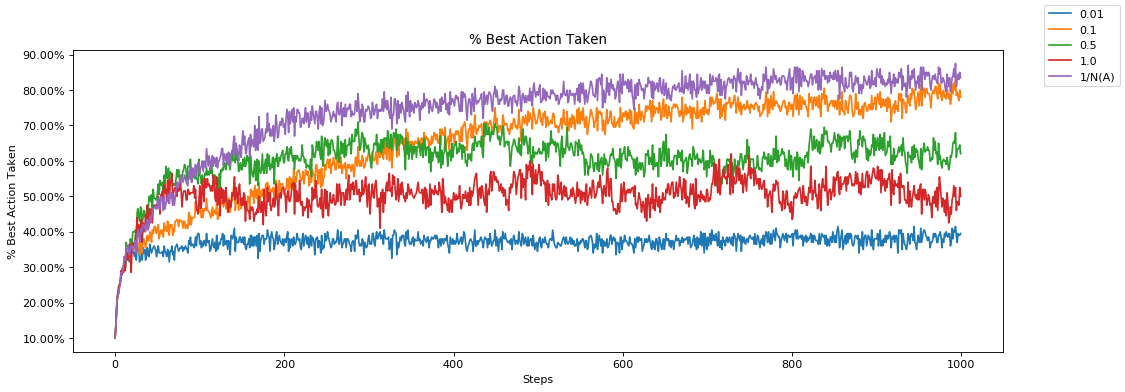

In [ ]:
# Experiment code for different step sizes [graded]
step_sizes = [0.01, 0.1, 0.5, 1.0]

epsilon = 0.1
num_steps = 1000
num_runs = 200

fig, ax = plt.subplots(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')

q_values = {step_size: [] for step_size in step_sizes}
true_values = {step_size: None for step_size in step_sizes}
best_actions = {step_size: [] for step_size in step_sizes}

for step_size in step_sizes:
    all_averages = []
    for run in tqdm(range(num_runs)):
        agent = EpsilonGreedyAgentConstantStepsize
        agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size, "initial_value": 0.0}
        env_info = {"random_seed": run}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()
        
        best_arm = np.argmax(rl_glue.environment.arms)

        scores = [0]
        averages = []
        
        if run == 0:
            true_values[step_size] = np.copy(rl_glue.environment.arms)
            
        best_action_chosen = []
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if run == 0:
                q_values[step_size].append(np.copy(rl_glue.agent.q_values))
        best_actions[step_size].append(best_action_chosen)
    ax.plot(np.mean(best_actions[step_size], axis=0))
    if step_size == 0.01:
        np.save("step_size", best_actions[step_size])
    
ax.plot(np.mean(n_best_actions, axis=0))
fig.legend(step_sizes + ["1/N(A)"])
plt.title("% Best Action Taken")
plt.xlabel("Steps")
plt.ylabel("% Best Action Taken")
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

Notice first that we are now plotting the amount of time that the best action is taken rather than the average reward. To better  understand the performance of an agent, it can be useful to measure specific behaviors, beyond just how much reward is accumulated. This measure indicates how close the agent’s behaviour is to optimal.

It seems as though 1/N(A) performed better than the others, in that it reaches a solution where it takes the best action most frequently. Now why might this be? Why did a step size of 0.5 start out better but end up performing worse? Why did a step size of 0.01 perform so poorly?

Let's dig into this further below. Let’s plot how well each agent tracks the true value, where each agent has a different step size method. You do not have to enter any code here, just follow along.

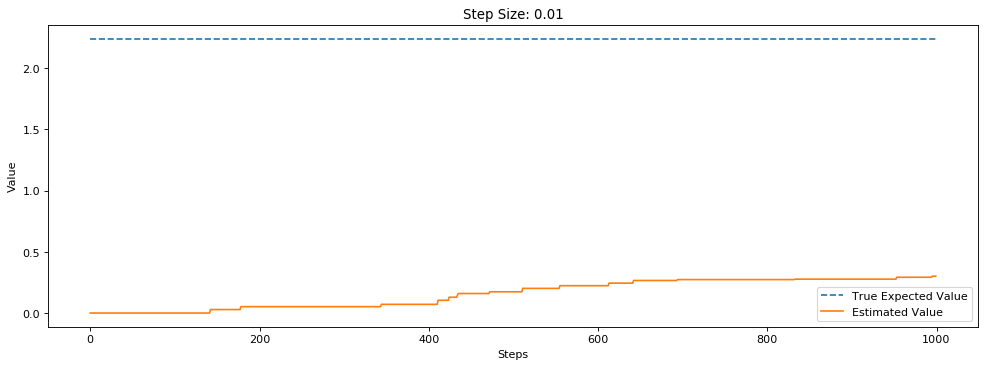

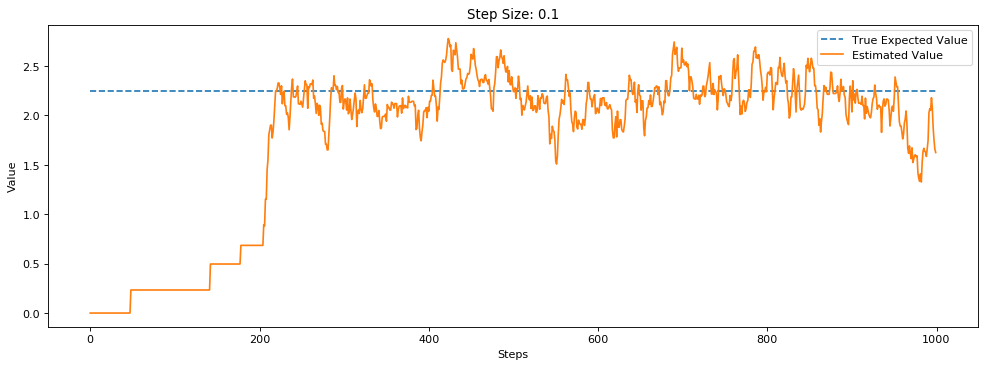

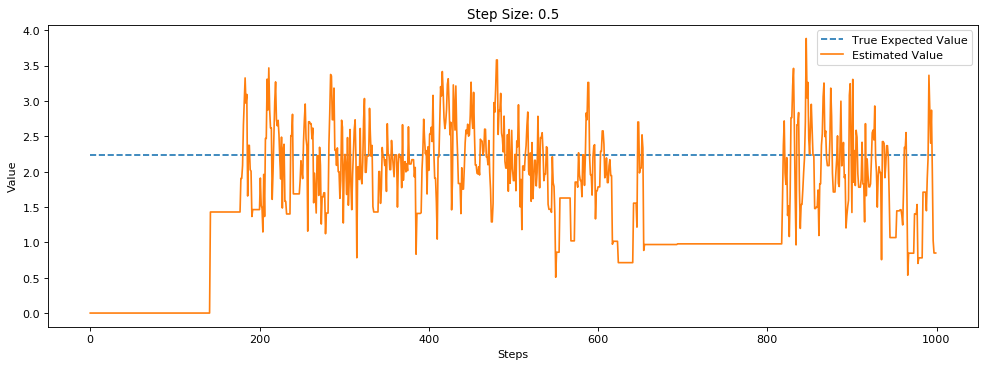

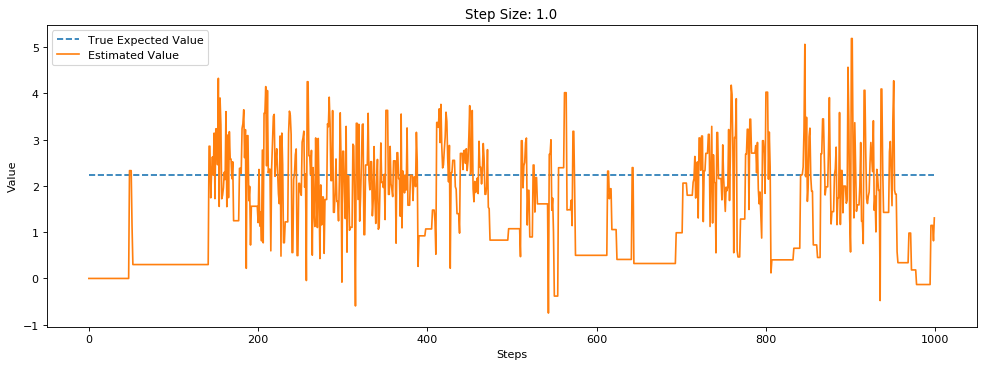

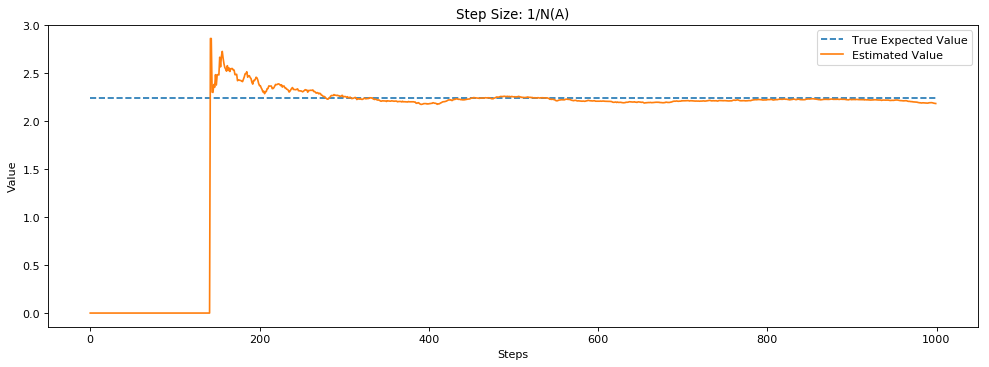

In [ ]:
# Plot various step sizes and estimates
largest = 0
num_steps = 1000
for step_size in step_sizes:
    plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
    largest = np.argmax(true_values[step_size])
    plt.plot([true_values[step_size][largest] for _ in range(num_steps)], linestyle="--")
    plt.title("Step Size: {}".format(step_size))
    plt.plot(np.array(q_values[step_size])[:, largest])
    plt.legend(["True Expected Value", "Estimated Value"])
    plt.xlabel("Steps")
    plt.ylabel("Value")
    plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.title("Step Size: 1/N(A)")
plt.plot([true_values[step_size][largest] for _ in range(num_steps)], linestyle="--")
plt.plot(np.array(n_q_values)[:, largest])
plt.legend(["True Expected Value", "Estimated Value"])
plt.xlabel("Steps")
plt.ylabel("Value")
plt.show()

These plots help clarify the performance differences between the different step sizes. A step size of 0.01 makes such small updates that the agent’s value estimate of the best action does not get close to the actual value. Step sizes of 0.5 and 1.0 both get close to the true value quickly, but are very susceptible to stochasticity in the rewards. The updates overcorrect too much towards recent rewards, and so oscillate around the true value. This means that on many steps, the action that pulls the best arm may seem worse than it actually is.  A step size of 0.1 updates fairly quickly to the true value, and does not oscillate as widely around the true values as 0.5 and 1.0. This is one of the reasons that 0.1 performs quite well. Finally we see why 1/N(A) performed well. Early on while the step size is still reasonably high it moves quickly to the true expected value, but as it gets pulled more its step size is reduced which makes it less susceptible to the stochasticity of the rewards.

Does this mean that 1/N(A) is always the best? When might it not be? One possible setting where it might not be as effective is in non-stationary problems. You learned about non-stationarity in the lessons. Non-stationarity means that the environment may change over time. This could manifest itself as continual change over time of the environment, or a sudden change in the environment.

Let's look at how a sudden change in the reward distributions affects a step size like 1/N(A). This time we will run the environment for 2000 steps, and after 1000 steps we will randomly change the expected value of all of the arms. We compare two agents, both using epsilon-greedy with epsilon = 0.1. One uses a constant step size of 0.1, the other a step size of 1/N(A) that reduces over time. 

In [ ]:
epsilon = 0.1
num_steps = 2000
num_runs = 200
step_size = 0.1

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

for agent in [EpsilonGreedyAgent, EpsilonGreedyAgentConstantStepsize]:
    all_averages = []
    for run in tqdm(range(num_runs)):
        agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size}
        env_info = {"random_seed": run}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()

        scores = [0]
        averages = []
        
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if i == 1000:
                rl_glue.environment.arms = np.random.randn(10)
        all_averages.append(averages)
        
    plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Best Possible", "1/N(A)", "0.1"])
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

 68%|██████▊   | 137/200 [00:06<00:02, 21.27it/s]

Now the agent with a step size of 1/N(A) performed better at the start but then performed worse when the environment changed! What happened?

Think about what the step size would be after 1000 steps. Let's say the best action gets chosen 500 times. That means the step size for that action is 1/500 or 0.002. At each step when we update the value of the action and the value is going to move only 0.002 * the error. That is a very tiny adjustment and it will take a long time for it to get to the true value.

The agent with step size 0.1, however, will always update in 1/10th of the direction of the error. This means that on average it will take ten steps for it to update its value to the sample mean.

These are the types of tradeoffs we have to think about in reinforcement learning. A larger step size moves us more quickly toward the true value, but can make our estimated values oscillate around the expected value. A step size that reduces over time can converge to close to the expected value, without oscillating. On the other hand, such a decaying stepsize is not able to adapt to changes in the environment. Nonstationarity---and the related concept of partial observability---is a common feature of reinforcement learning problems and when learning online.  

## Section 5: Conclusion

Great work! You have:
- Implemented your first agent
- Learned about the effect of epsilon, an exploration parameter, on the performance of an agent
- Learned about the effect of step size on the performance of the agent
- Learned about a good experiment practice of averaging across multiple runs